# SRA Pre-Alignment Summary

In [2]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd
from IPython.display import display

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-03-17 
Git hash: 94bf3c7800181bc8d9e74dfcc5a177068858242a


In [3]:
#
def pretty_numbers(x):
    return '{:,}'.format(x)

**Objective:** 
* Identify which SRX/SRR are *paired-end libraries* so that proper alignment parameters can be used.
* Identify which SRX/SRR are *stranded libraries* so that proper alignment parameters can be used.
* Identify which SRX/SRR should be remapped.

**Method:**
* Download a subset of 1,000,000 reads from each SRR and run various QC metrics

**Results:**
* WIP

## SRA Database Dump

In [4]:
# Connect to mongodb
from pymongo import MongoClient
client = MongoClient(host='localhost', port=27022)
db = client['sra2']
remap = db.remap
ncbi = db.ncbi

In [5]:
# SRR to SRX
srrToSrx = pd.DataFrame(
    list(
        remap.aggregate([
            {'$unwind': '$runs'},
            {'$group': {'_id': {'srr': '$runs.srr', 'srx': '$_id'}}},
            {'$project': {'_id': 0, 'srr': '$_id.srr', 'srx': '$_id.srx'}}
        ])
    ),
)
srrToSrx.set_index('srr', inplace=True)

numSRX = pretty_numbers(len(srrToSrx.srx.unique()))
numSRR = pretty_numbers(len(srrToSrx.index.unique()))

In [6]:
# make a list of srr to library strategy, source, selection
srrToMethod = pd.DataFrame(
    list(
        ncbi.aggregate([
            {'$unwind': '$sra.run'},
            {
                '$project':{
                    '_id': 0,
                    'srr': '$sra.run.run_id',
                    'source': '$sra.experiment.library_source',
                    'strategy': '$sra.experiment.library_strategy',
                    'selection': '$sra.experiment.library_selection',
                }
            },
        ])
    )
)

srrToMethod.set_index('srr', inplace=True)

In [7]:
# get a list of brian's data
oliver = pd.DataFrame(
    list(
        remap.aggregate([
            {'$unwind': '$runs'},
            {
                '$match': {
                    '$and': [
                        {'contacts.first_name': 'Brian'},
                        {'contacts.last_name': 'Oliver'},
                    ]
                }
            },
            {'$group': {'_id': {'srr': '$runs.srr', 'srx': '$_id'}}},
            {'$project': {'_id': 0, 'srr': '$_id.srr', 'srx': '$_id.srx'}}
        ])
    ),
)
oliver.set_index('srr', inplace=True)

In [8]:
# get a list of our golden set
with open('../../data/312_sample_golden_set_2016-06-14.txt', 'r') as fh:
    goldenList = [x.strip() for x in fh.readlines()]
    
golden = pd.DataFrame(
    list(
        remap.aggregate([
            {'$unwind': '$runs'},
            {
                '$match': {
                    'runs.srr': {'$in': goldenList},
                }
            },
            {'$group': {'_id': {'srr': '$runs.srr', 'srx': '$_id'}}},
            {'$project': {'_id': 0, 'srr': '$_id.srr', 'srx': '$_id.srx'}}
        ])
    ),
)
golden.set_index('srr', inplace=True)

There are **{{numSRX}} SRXs** and **{{numSRR}} SRRs**, downloaded from the SRA database using the query **'"Drosophila melanogaster"[orgn]'** on **February 27, 2017**.

## Determine Layout (Single vs Paired Ended)

Each SRR was downloaded and FASTQ files were extracted using `fastq-dump`. If two files were created (pair-end: PE) files were checked for content, if there was not content in both files (or if only 1 file was created) the SRR was assigned as single-end (SE). These were then compared to database annotations to identify differences.

There are 1,490 SRRs that I have not been able to download ('UNDETERMINED'). There are 126 SRRs that are annotated as being PE, but appear to be SE. There are 437 SRRs annotated as SE that appear to be PE. However, most of these 437 appear to be instances where the index was uploaded as a separate read pair (see blue line in figure), so in reality most of these 437 should be treated as SE using only read 2. However, these read lengths are from the SRA, so they need to be empirically validate. 

In [9]:
# Get layouts
# Get SRA's annotation for layout
ncbiEnds = pd.DataFrame(
    list(
        ncbi.aggregate([
            {'$unwind': '$sra.run'},
            {'$unwind': '$sra.db_flags'},
            {'$match': {'$or': [{'sra.db_flags': 'SE'}, {'sra.db_flags': 'PE'}]}},
            {'$group': {'_id': {'srr': '$sra.run.run_id', 'db_flags': '$sra.db_flags'}}},
            {'$project': {'_id': 0, 'srr': '$_id.srr', 'db_flags': '$_id.db_flags'}}
        ])
        
    )
)
ncbiEnds.set_index('srr', inplace=True)
ncbiEnds.columns = ['Layout SRA Database']

# Get FASTQ Dump Layout results
remapEnds = pd.DataFrame(
    list(
        remap.aggregate([
            {'$unwind': '$runs'},
            {'$unwind': '$runs.pre_aln_flags'},
            {'$match': {'$or': [{'runs.pre_aln_flags': 'SE'}, {'runs.pre_aln_flags': 'PE'}]}},
            {'$group': {'_id': {'srr': '$runs.srr', 'pre_aln_flags': '$runs.pre_aln_flags'}}},
            {'$project': {'_id': 0, 'srr': '$_id.srr', 'pre_aln_flags': '$_id.pre_aln_flags'}}
        ])
        
    )
)
remapEnds.set_index('srr', inplace=True)
remapEnds.columns = ['Layout fastq-dump']

# Make crostab
layout = ncbiEnds.join(remapEnds, how='outer')
layout.fillna('UNDETERMINED', inplace=True)
pd.crosstab(layout.iloc[:, 0], layout.iloc[:, 1], margins=True).applymap(pretty_numbers)

Layout fastq-dump,PE,SE,UNDETERMINED,All
Layout SRA Database,,,,
PE,"9,309",126,463,"9,898"
SE,437,"24,020","1,027","25,484"
All,"9,746","24,146","1,490","35,382"


In [10]:
# Double check that there are SE that look to be PE
sePE = layout[(layout['Layout SRA Database'] == 'SE') & (layout['Layout fastq-dump'] == 'PE')].index.values.tolist()

# pull out SRA read lengths
readLen = pd.DataFrame(list(
    ncbi.aggregate([
        {'$unwind': '$sra.run'},
        {
            '$match': {
                'sra.run.run_id': {'$in': sePE}
            }
        }, 
        {
            '$group': {
                '_id': { 
                    'srr': '$sra.run.run_id', 
                    'r1_len': '$sra.run.read_len_r1', 
                    'r2_len': '$sra.run.read_len_r2'
                }
            }
        },
        {
            '$project': {
                '_id': 0,
                'srr': '$_id.srr', 
                'r1_len': '$_id.r1_len', 
                'r2_len': '$_id.r2_len'
            }
        }
    ])
))
readLen.set_index('srr', inplace=True)

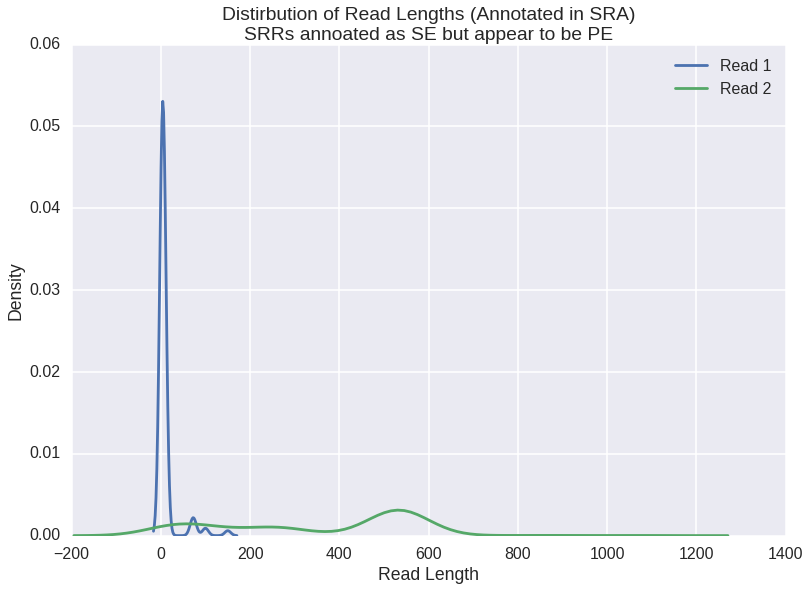

In [11]:
# Plot distribution of read length of SRR that are annot
sns.distplot(readLen['r1_len'].dropna(), hist=False, label='Read 1')
ax = sns.distplot(readLen['r2_len'].dropna(), hist=False, label='Read 2')
_ = ax.legend()
_ = ax.set_title('Distirbution of Read Lengths (Annotated in SRA)\nSRRs annoated as SE but appear to be PE')
_ = ax.set_xlabel('Read Length')
_ = ax.set_ylabel('Density')
_ = ax.set_ylim(0, 0.06)

## Unique SRRs

I am concerned that the same FASTQ file may have been uploaded twice. To check if this is a problem I have used a hashing algorithm (md5sum) to hash each FASTQ. I don't have all of the data in yet, but so far I do not see anything that is an exact duplicate. The Thierry-Miegs have identified a set of SRRs as being duplicated, but I am not sure on their criteria. The hashing method that I used will not work if there is any kind of change to the data. If there is an extra white space at the end of the file, this would change the hashes. 

In [12]:
# Check md5
md5 = pd.read_csv('../../output/prealignment/agg/se_md5.tsv', sep='\t')

# Count number of exact duplicates
md5cnts = pd.DataFrame(md5.groupby('md5').count().groupby('sample').size())
md5cnts.columns = ['# SRR']
md5cnts.index.name = '# Duplicates'
display(md5cnts.applymap(pretty_numbers))

# show duplicated ids
print('Duplicated SRRs')
md5[md5['md5'].duplicated()]

,# SRR
# Duplicates,
1,"18,387"


Duplicated SRRs


,sample,md5


## Strandedness

When aligning it is important to know if the library is stranded. Strandedness describes if a read aligns to the same strand as the gene which it came from. A Forward stranded library aligns to the same strand as the references '++' or '--'. Reverse strandedness means a read aligns to the opposite strand as the reference '+-' or '-+'. Illiumina stranded protocol produces reads that are reverse stranded. 

I used several different tools to look at strandedness. They all basically do the same thing; align the read, determine if it overlaps a gene model, and determine if the read is forward or reverse stranded. Looking at the below plots, I would set a cutoff of around 0.2% to say an SRR is reverse stranded and around 0.8% to say a library is forward stranded.

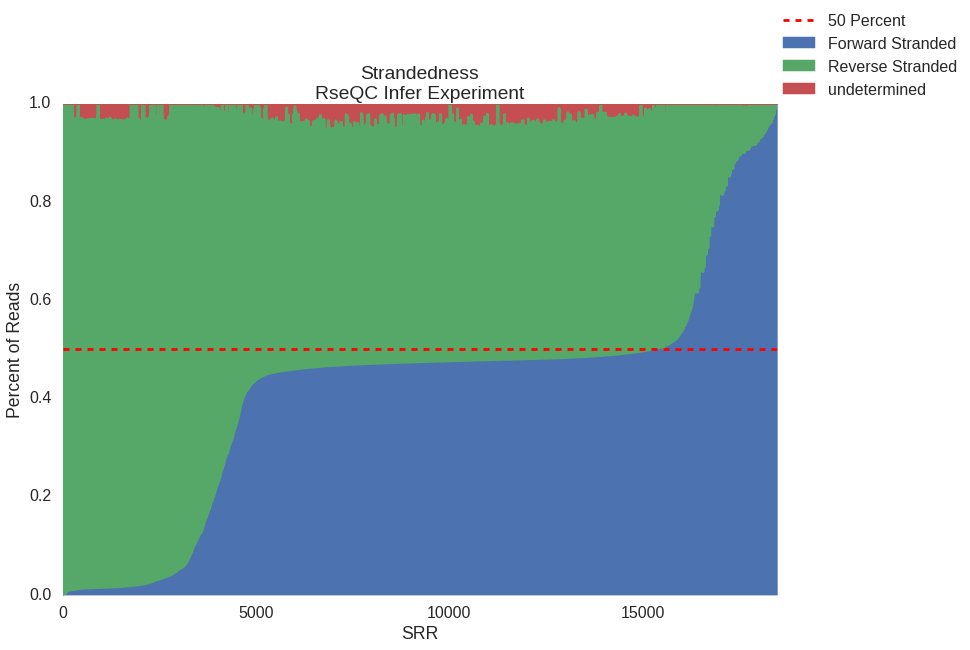

In [13]:
# rseqc infer experiment
infer = pd.read_csv('../../output/prealignment/agg/se_inferExperiment.tsv', sep='\t')
infer.columns = ['srr', 'undetermined', 'Forward Stranded', 'Reverse Stranded']
infer.set_index('srr', inplace=True)
infer.sort_values(by='Forward Stranded', inplace=True)

# draw area plot
ax = infer[['Forward Stranded', 'Reverse Stranded', 'undetermined']].plot.area(legend=False, stacked=True, use_index=False)
_ = ax.axhline(0.5, ls='--', color='r', label='50 Percent')
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, loc=(1, 1))
_ = ax.set_ylim(0, 1)
_ = ax.set_ylabel('Percent of Reads')
_ = ax.set_xlabel('SRR')
_ = ax.set_title('Strandedness\nRseQC Infer Experiment')

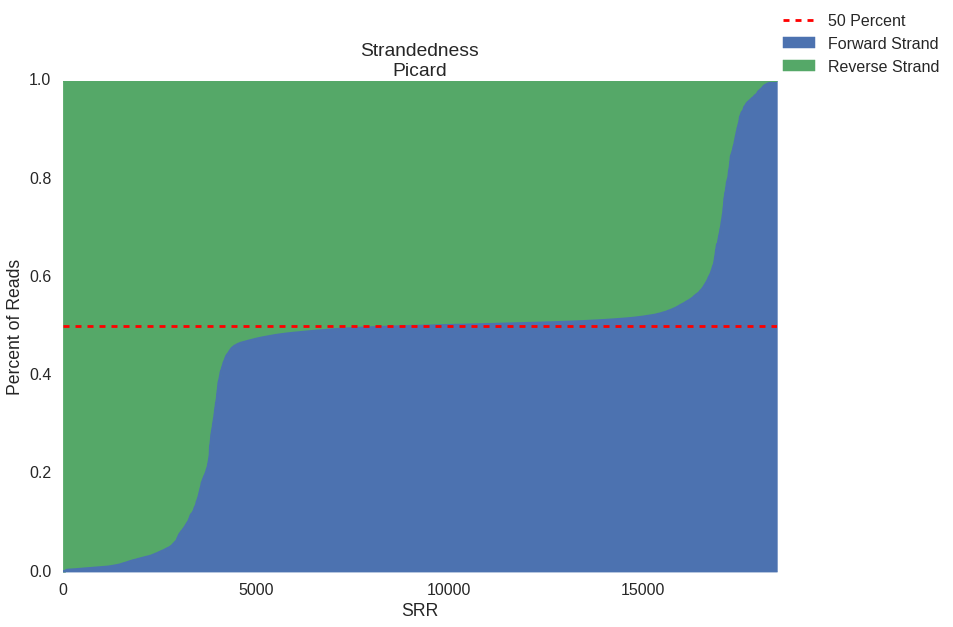

In [14]:
# picard strandedness
picard_rna = pd.read_csv('../../output/prealignment/agg/se_picard_collectrnaseqmetrics_first_summary.tsv', sep='\t', index_col=0)
picard_strand = pd.DataFrame(picard_rna['PCT_CORRECT_STRAND_READS'].copy())
picard_strand.columns = ['Forward Strand']
picard_strand['Reverse Strand'] = 1 - picard_strand['Forward Strand']
picard_strand.sort_values('Forward Strand', inplace=True)

# plot area
ax = picard_strand.plot.area(stacked=True, legend=False, use_index=False)
_ = ax.axhline(0.5, ls='--', color='r', label='50 Percent')
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, loc=(1, 1))
_ = ax.set_ylim(0, 1)
_ = ax.set_ylabel('Percent of Reads')
_ = ax.set_xlabel('SRR')
_ = ax.set_title('Strandedness\nPicard')

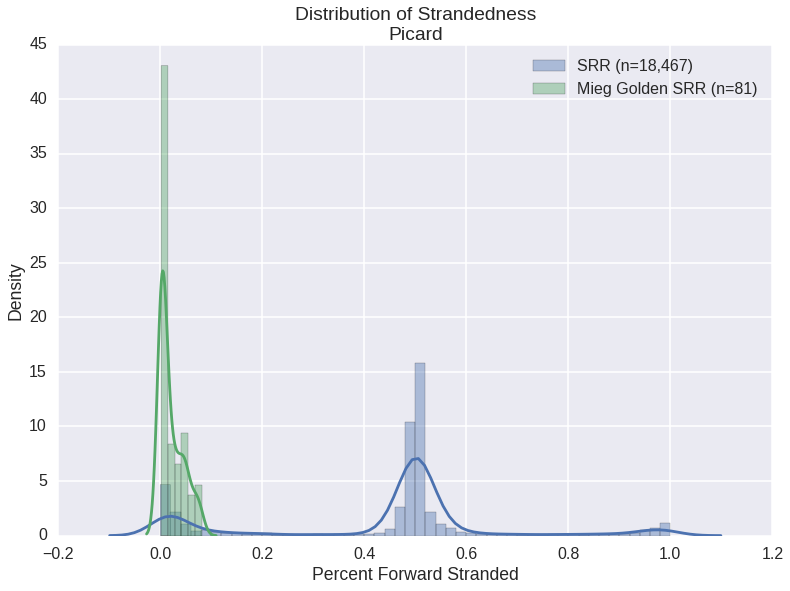

In [16]:
# distirbution of first strandedness
picard_oliver = picard_strand[picard_strand.index.isin(oliver.index)]
picard_golden = picard_strand[picard_strand.index.isin(golden.index)]
ax = sns.distplot(picard_strand['Forward Strand'], label='SRR (n={:,})'.format(len(picard_strand)))
#_ = sns.distplot(picard_oliver['Forward Strand'], label='Oliver SRR (n={:,})'.format(len(picard_oliver)))
_ = sns.distplot(picard_golden['Forward Strand'], label='Mieg Golden SRR (n={:,})'.format(len(picard_golden)))
_ = ax.set_title('Distribution of Strandedness\nPicard')
_ = ax.set_xlabel('Percent Forward Stranded')
_ = ax.set_ylabel('Density')
_ = ax.legend()

In [14]:
# Create lists of SRR using cutoff
reverse = picard_strand[picard_strand['Forward Strand'] < 0.2].index.tolist()
forward = picard_strand[picard_strand['Forward Strand'] > 0.8].index.tolist()
unstrand = picard_strand[(picard_strand['Forward Strand'] > 0.2) & (picard_strand['Forward Strand'] < 0.8)].index.tolist()

strandCnt = pd.DataFrame({
    'Reverse Stranded': len(reverse),
    'Forward Stranded': len(forward),
    'Non Stranded': len(unstrand),
}, index=['# SRR'])

strandCnt.applymap(pretty_numbers).T

,# SRR
Forward Stranded,"1,254"
Non Stranded,"13,500"
Reverse Stranded,"3,705"


## Alignment Location

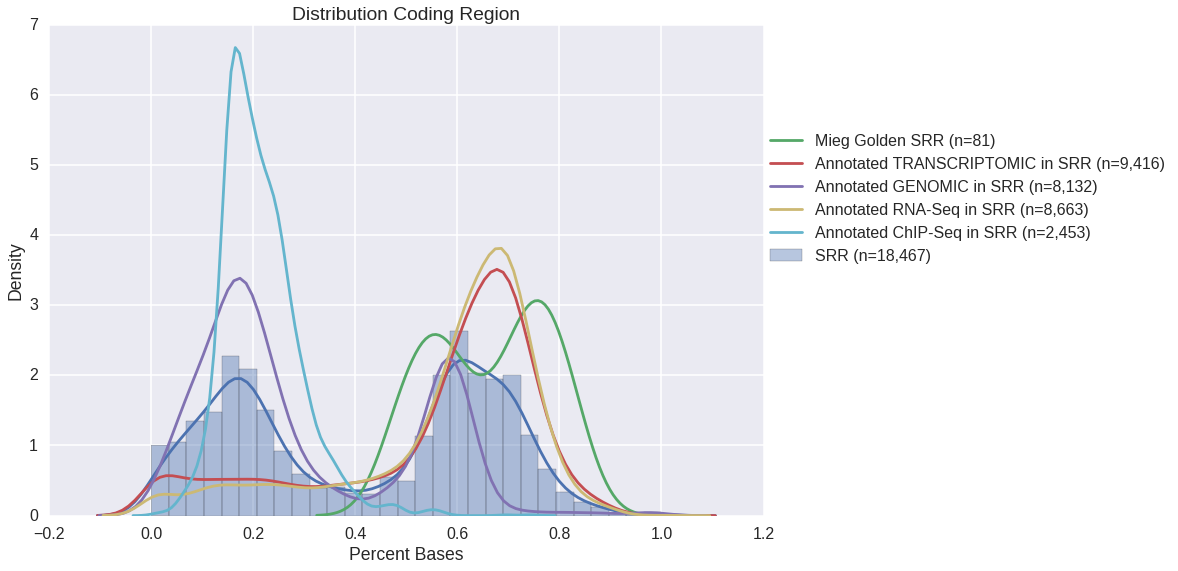

In [17]:
# Distribution Picard coding
picard_coding =  picard_rna['PCT_CODING_BASES'].copy()

numCoding = len(picard_coding)
ax = sns.distplot(picard_coding, label='SRR (n={:,})'.format(numCoding))

oliver_coding = picard_coding[picard_coding.index.isin(oliver.index)]
#_ = sns.distplot(oliver_coding, hist=False, ax=ax, label='Oliver SRR (n={:,})'.format(len(oliver_coding)))

golden_coding = picard_coding[picard_coding.index.isin(golden.index)]
_ = sns.distplot(golden_coding, hist=False, ax=ax, label='Mieg Golden SRR (n={:,})'.format(len(golden_coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'TRANSCRIPTOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated TRANSCRIPTOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'GENOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated GENOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'RNA-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated RNA-Seq in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'ChIP-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated ChIP-Seq in SRR (n={:,})'.format(len(coding)))

_ = ax.set_title('Distribution Coding Region')
_ = ax.set_xlabel('Percent Bases')
_ = ax.set_ylabel('Density')
_ = ax.legend(loc=(1, 0.5))


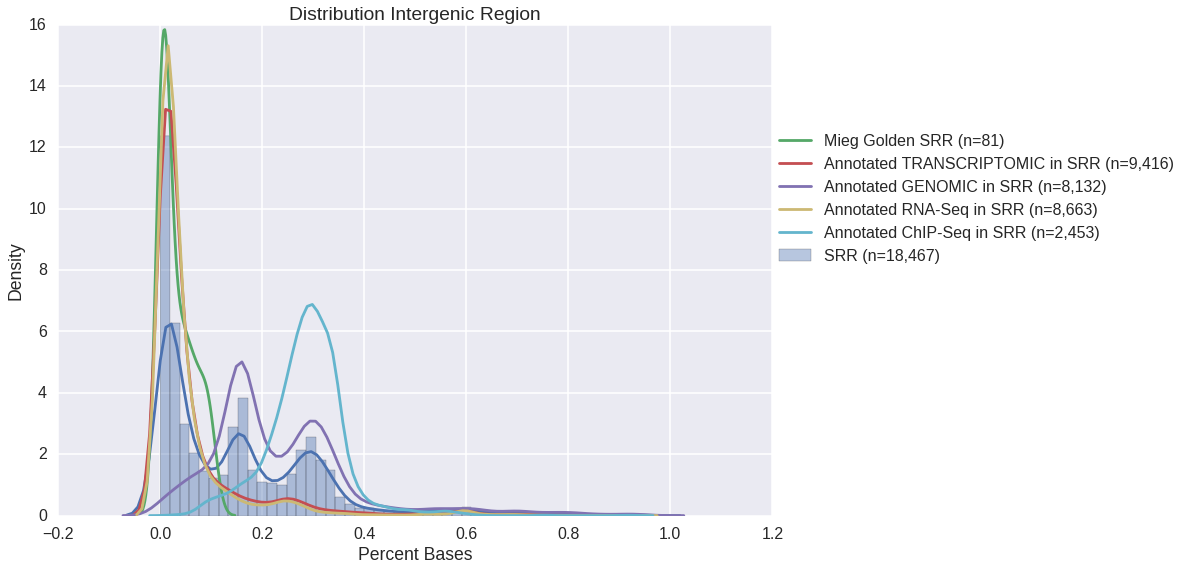

In [18]:
# Distribution Picard intergenic 
picard_coding =  picard_rna['PCT_INTERGENIC_BASES'].copy()

numCoding = len(picard_coding)
ax = sns.distplot(picard_coding, label='SRR (n={:,})'.format(numCoding))

oliver_coding = picard_coding[picard_coding.index.isin(oliver.index)]
#_ = sns.distplot(oliver_coding, hist=False, ax=ax, label='Oliver SRR (n={:,})'.format(len(oliver_coding)))

golden_coding = picard_coding[picard_coding.index.isin(golden.index)]
_ = sns.distplot(golden_coding, hist=False, ax=ax, label='Mieg Golden SRR (n={:,})'.format(len(golden_coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'TRANSCRIPTOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated TRANSCRIPTOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'GENOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated GENOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'RNA-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated RNA-Seq in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'ChIP-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated ChIP-Seq in SRR (n={:,})'.format(len(coding)))

_ = ax.set_title('Distribution Intergenic Region')
_ = ax.set_xlabel('Percent Bases')
_ = ax.set_ylabel('Density')
_ = ax.legend(loc=(1, 0.5))


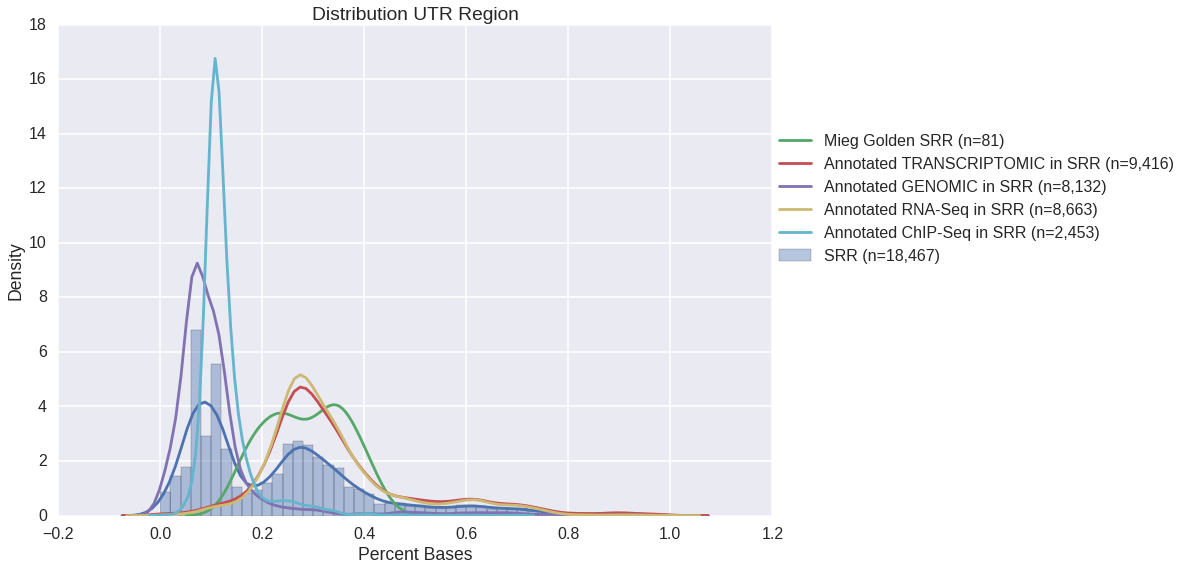

In [19]:
# Distribution Picard UTR
picard_coding =  picard_rna['PCT_UTR_BASES'].copy()

numCoding = len(picard_coding)
ax = sns.distplot(picard_coding, label='SRR (n={:,})'.format(numCoding))

oliver_coding = picard_coding[picard_coding.index.isin(oliver.index)]
#_ = sns.distplot(oliver_coding, hist=False, ax=ax, label='Oliver SRR (n={:,})'.format(len(oliver_coding)))

golden_coding = picard_coding[picard_coding.index.isin(golden.index)]
_ = sns.distplot(golden_coding, hist=False, ax=ax, label='Mieg Golden SRR (n={:,})'.format(len(golden_coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'TRANSCRIPTOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated TRANSCRIPTOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'GENOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated GENOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'RNA-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated RNA-Seq in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'ChIP-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated ChIP-Seq in SRR (n={:,})'.format(len(coding)))

_ = ax.set_title('Distribution UTR Region')
_ = ax.set_xlabel('Percent Bases')
_ = ax.set_ylabel('Density')
_ = ax.legend(loc=(1, 0.5))


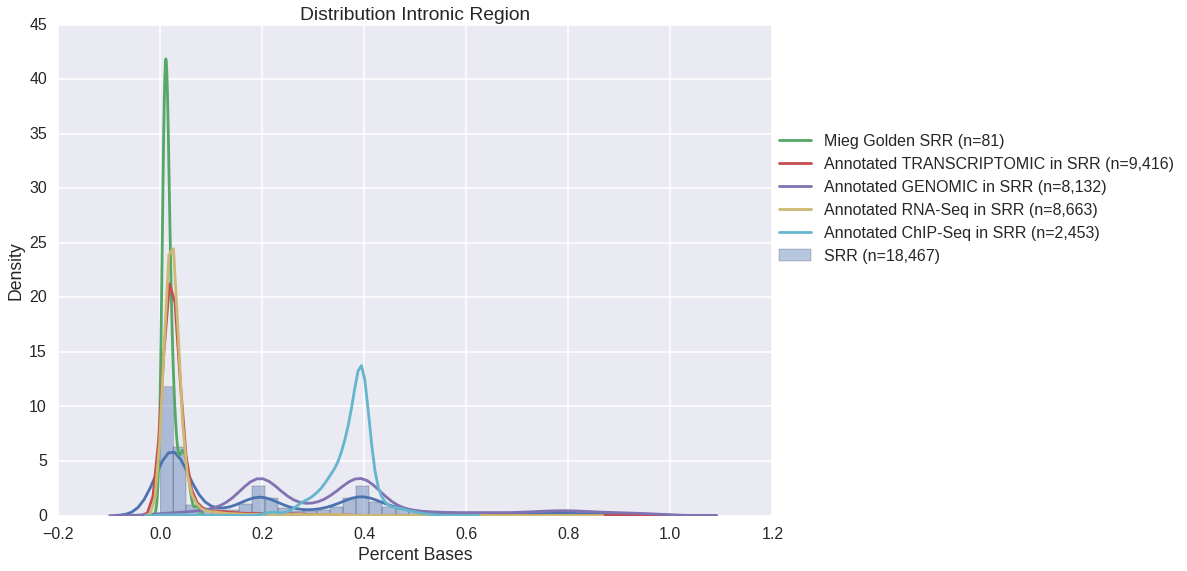

In [20]:
# Distribution Picard intron
picard_coding =  picard_rna['PCT_INTRONIC_BASES'].copy()

numCoding = len(picard_coding)
ax = sns.distplot(picard_coding, label='SRR (n={:,})'.format(numCoding))

oliver_coding = picard_coding[picard_coding.index.isin(oliver.index)]
#_ = sns.distplot(oliver_coding, hist=False, ax=ax, label='Oliver SRR (n={:,})'.format(len(oliver_coding)))

golden_coding = picard_coding[picard_coding.index.isin(golden.index)]
_ = sns.distplot(golden_coding, hist=False, ax=ax, label='Mieg Golden SRR (n={:,})'.format(len(golden_coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'TRANSCRIPTOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated TRANSCRIPTOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['source'] == 'GENOMIC'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated GENOMIC in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'RNA-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated RNA-Seq in SRR (n={:,})'.format(len(coding)))

coding = picard_coding[picard_coding.index.isin(srrToMethod[srrToMethod['strategy'] == 'ChIP-Seq'].index)]
_ = sns.distplot(coding, hist=False, ax=ax, label='Annotated ChIP-Seq in SRR (n={:,})'.format(len(coding)))

_ = ax.set_title('Distribution Intronic Region')
_ = ax.set_xlabel('Percent Bases')
_ = ax.set_ylabel('Density')
_ = ax.legend(loc=(1, 0.5))


In [56]:
# Make flags and merge on methods
picard_flags = srrToMethod[srrToMethod.index.isin(picard_coding.index)].copy()
picard_flags.loc[picard_coding['PCT_CODING_BASES'] > .4, 'pct coding gt 0.4'] = True
picard_flags.loc[picard_coding['PCT_INTERGENIC_BASES'] < .1, 'pct intergenic lt 0.1'] = True
picard_flags.loc[picard_coding['PCT_UTR_BASES'] < .2, 'pct utr lt 0.2'] = True
picard_flags.loc[picard_coding['PCT_INTRONIC_BASES'] < .1, 'pct intronic lt 0.1'] = True
picard_flags.fillna(False, inplace=True)

In [107]:
melted = pd.melt(picard_flags, id_vars=['selection', 'source', 'strategy'], value_vars=['pct coding gt 0.4', 'pct intergenic lt 0.1', 'pct utr lt 0.2', 'pct intronic lt 0.1'])

In [114]:
display(pd.crosstab(melted.selection, [melted['variable'], melted['value']]))
display(pd.crosstab(melted.source, [melted['variable'], melted['value']]))
display(pd.crosstab(melted.strategy, [melted['variable'], melted['value']]))

variable                  pct coding gt 0.4       pct intergenic lt 0.1        \
value                                 False True                  False True    
selection                                                                       
5-methylcytidine antibody                 3     0                     3     0   
CAGE                                     32     0                     0    32   
ChIP                                   2379    51                  2388    42   
DNAse                                    20     2                    20     2   
MNase                                     9     0                     9     0   
Oligo-dT                                 20    16                     1    35   
PCR                                       9   108                     9   108   
PolyA                                     1    61                     2    60   
RANDOM                                  506  2104                   499  2111   
RANDOM PCR                                0    27                     0    27   
RT-PCR                                   61    38                    31    68   
Reduced Representation                   83  2241                  2323     1   
cDNA                                   1151  5024                   771  5404   
other                                  3763   311                  3069  1005   
size fractionation                      339    31                   307    63   
unspecified                              65    12                    61    16   

variable                  pct intronic lt 0.1       pct utr lt 0.2        
value                                   False True           False True   
selection                                                                 
5-methylcytidine antibody                   3     0              0     3  
CAGE                                        0    32             32     0  
ChIP                                     2418    12            168  2262  
DNAse                                      20     2              5    17  
MNase                                       9     0              0     9  
Oligo-dT                                    9    27             25    11  
PCR                                        10   107             90    27  
PolyA                                       0    62             51    11  
RANDOM                                    486  2124           2054   556  
RANDOM PCR                                  0    27              6    21  
RT-PCR                                     24    75             80    19  
Reduced Representation                   2324     0              0  2324  
cDNA                                      176  5999           5791   384  
other                                    3581   493            723  3351  
size fractionation                        128   242            304    66  
unspecified                                49    28             29    48

variable           pct coding gt 0.4       pct intergenic lt 0.1        \
value                          False True                  False True    
source                                                                   
GENOMIC                         5569  2563                  7158   974   
METAGENOMIC                        9     0                     9     0   
METATRANSCRIPTOMIC                 0    42                     0    42   
OTHER                            102     0                    82    20   
SYNTHETIC                        765     1                   765     1   
TRANSCRIPTOMIC                  1996  7420                  1479  7937   

variable           pct intronic lt 0.1       pct utr lt 0.2        
value                            False True           False True   
source                                                             
GENOMIC                           7817   315            620  7512  
METAGENOMIC                          9     0              0     9  
METATRANSCRIPTOMIC                   0    42             42     0  
OTHER                               73    29             54    48  
SYNTHETIC                          764     2              5   761  
TRANSCRIPTOMIC                     574  8842           8637   779

variable               pct coding gt 0.4       pct intergenic lt 0.1        \
value                              False True                  False True    
strategy                                                                     
AMPLICON                               3    80                     3    80   
Bisulfite-Seq                          4     0                     3     1   
CLONEEND                               7     0                     7     0   
ChIP-Seq                            2402    51                  2411    42   
DNase-Hypersensitivity                22     0                    22     0   
EST                                   68    85                    18   135   
FAIRE-seq                             13     2                    15     0   
FL-cDNA                                3     0                     1     2   
MNase-Seq                              9     0                     9     0   
MeDIP-Seq                              6     0                     6     0   
OTHER                               3774  2566                  5284  1056   
POOLCLONE                              0     4                     0     4   
RIP-Seq                               43     9                    32    20   
RNA-Seq                             1448  7215                  1078  7585   
WGA                                    2     0                     2     0   
WGS                                  445     2                   447     0   
miRNA-Seq                            114    11                    85    40   
ncRNA-Seq                             78     1                    70     9   

variable               pct intronic lt 0.1       pct utr lt 0.2        
value                                False True           False True   
strategy                                                               
AMPLICON                                 3    80             80     3  
Bisulfite-Seq                            4     0              1     3  
CLONEEND                                 6     1              4     3  
ChIP-Seq                              2441    12            168  2285  
DNase-Hypersensitivity                  22     0              3    19  
EST                                     19   134             90    63  
FAIRE-seq                               13     2              0    15  
FL-cDNA                                  0     3              3     0  
MNase-Seq                                9     0              0     9  
MeDIP-Seq                                6     0              0     6  
OTHER                                 5815   525            731  5609  
POOLCLONE                                0     4              0     4  
RIP-Seq                                 19    33             48     4  
RNA-Seq                                357  8306           8046   617  
WGA                                      2     0              0     2  
WGS                                    447     0              0   447  
miRNA-Seq                               25   100            118     7  
ncRNA-Seq                               49    30             66    13

In [307]:
first_counts = pd.read_csv('../../output/prealignment/agg/se_feature_counts_summary_first.tsv', sep='\t', index_col=0)
second_counts = pd.read_csv('../../output/prealignment/agg/se_feature_counts_summary_second.tsv', sep='\t', index_col=0)

In [311]:
first_counts.sort_index().head(100)

,Assigned,Unassigned_Ambiguity,Unassigned_MultiMapping,Unassigned_NoFeatures,Unassigned_Unmapped,Unassigned_MappingQuality,Unassigned_FragmentLength,Unassigned_Chimera,Unassigned_Secondary,Unassigned_Nonjunction,Unassigned_Duplicate
DRR001445,101824,2048,216965,538086,294534,0,0,0,0,0,0
DRR001446,65213,1511,148433,364066,525357,0,0,0,0,0,0
DRR001447,95019,1979,220567,525818,312502,0,0,0,0,0,0
DRR014222,608652,18608,31387,5133,355322,0,0,0,0,0,0
DRR014224,662738,19121,19910,3738,305803,0,0,0,0,0,0
DRR016398,474470,11434,81168,443806,39880,0,0,0,0,0,0
DRR016399,464736,13373,97440,444467,40205,0,0,0,0,0,0
DRR016400,471409,12213,104265,442283,35884,0,0,0,0,0,0
DRR016401,470389,14615,90922,445953,34010,0,0,0,0,0,0
DRR016402,467810,5549,26708,461136,56356,0,0,0,0,0,0


In [312]:
second_counts.sort_index().head(100)

,Assigned,Unassigned_Ambiguity,Unassigned_MultiMapping,Unassigned_NoFeatures,Unassigned_Unmapped,Unassigned_MappingQuality,Unassigned_FragmentLength,Unassigned_Chimera,Unassigned_Secondary,Unassigned_Nonjunction,Unassigned_Duplicate
DRR001445,97835,2020,216965,542103,294534,0,0,0,0,0,0
DRR001446,61288,1451,148433,368051,525357,0,0,0,0,0,0
DRR001447,87697,1911,220567,533208,312502,0,0,0,0,0,0
DRR014222,17727,220,31387,614446,355322,0,0,0,0,0,0
DRR014224,22814,312,19910,662471,305803,0,0,0,0,0,0
DRR016398,473424,10340,81168,445946,39880,0,0,0,0,0,0
DRR016399,464212,12061,97440,446303,40205,0,0,0,0,0,0
DRR016400,469441,11424,104265,445040,35884,0,0,0,0,0,0
DRR016401,467352,13112,90922,450493,34010,0,0,0,0,0,0
DRR016402,466250,5587,26708,462658,56356,0,0,0,0,0,0


In [330]:
forward_count = first_counts[first_counts.index.isin(forward)].copy()
reverse_count = second_counts[second_counts.index.isin(reverse)].copy()

In [332]:
non_forward_count = first_counts[first_counts.index.isin(unstrand)].copy()
non_reverse_count = second_counts[second_counts.index.isin(unstrand)].copy()

In [336]:
non_forward_count.sort_index().head()

,Assigned,Unassigned_Ambiguity,Unassigned_MultiMapping,Unassigned_NoFeatures,Unassigned_Unmapped,Unassigned_MappingQuality,Unassigned_FragmentLength,Unassigned_Chimera,Unassigned_Secondary,Unassigned_Nonjunction,Unassigned_Duplicate
DRR001445,101824,2048,216965,538086,294534,0,0,0,0,0,0
DRR001446,65213,1511,148433,364066,525357,0,0,0,0,0,0
DRR001447,95019,1979,220567,525818,312502,0,0,0,0,0,0
DRR016398,474470,11434,81168,443806,39880,0,0,0,0,0,0
DRR016399,464736,13373,97440,444467,40205,0,0,0,0,0,0


In [335]:
non_reverse_count.sort_index().head()

,Assigned,Unassigned_Ambiguity,Unassigned_MultiMapping,Unassigned_NoFeatures,Unassigned_Unmapped,Unassigned_MappingQuality,Unassigned_FragmentLength,Unassigned_Chimera,Unassigned_Secondary,Unassigned_Nonjunction,Unassigned_Duplicate
DRR001445,97835,2020,216965,542103,294534,0,0,0,0,0,0
DRR001446,61288,1451,148433,368051,525357,0,0,0,0,0,0
DRR001447,87697,1911,220567,533208,312502,0,0,0,0,0,0
DRR016398,473424,10340,81168,445946,39880,0,0,0,0,0,0
DRR016399,464212,12061,97440,446303,40205,0,0,0,0,0,0


In [340]:
non_reverse_count.columns

Index(['Assigned', 'Unassigned_Ambiguity', 'Unassigned_MultiMapping',
       'Unassigned_NoFeatures', 'Unassigned_Unmapped',
       'Unassigned_MappingQuality', 'Unassigned_FragmentLength',
       'Unassigned_Chimera', 'Unassigned_Secondary', 'Unassigned_Nonjunction',
       'Unassigned_Duplicate'],
      dtype='object')

In [ ]:
non_reverse_count[[]]

In [62]:
# Transcriptomic SRRs
srxToAnnoRNA = pd.DataFrame(
    list(
        ncbi.aggregate([
            {
                '$project': {
                    '_id': 0, 
                    'srx': '$_id',
                    'selection': '$sra.experiment.library_selection',
                    'flag_annoRNA': {
                        '$cond': {
                            'if': {
                                    '$or': [
                                        {'$eq': ['$sra.experiment.library_strategy', 'RNA-Seq']},
                                        {'$eq': ['$sra.experiment.library_source', 'TRANSCRIPTOMIC']},
                                    ]
                                  },
                            'then': 1,
                            'else': 0
                        }
                    }
                }
            },
        ])
    )
)
srxToAnnoRNA.set_index('srx', inplace=True)
numSrx = '{:,}'.format(len(srxToAnnoRNA))
numSrxAnnoRNA = '{:,}'.format(srxToAnnoRNA.flag_annoRNA.sum())

Of the {{numSrx}} SRXs, there are {{numSrxAnnoRNA}} SRX annotated as either RNA-Seq or Transcriptomic. Of the {{numSrxAnnoRNA}} a variety of RNA selection methods are provided; below are the counts for different selection types.

In [66]:
# counts of selection types
cnt = srxToAnnoRNA.where(srxToAnnoRNA['flag_annoRNA'] == 1).groupby('selection').count()
cnt.columns = ['# SRX']
cnt

,# SRX
selection,
CAGE,312
ChIP,1
DNAse,180
Hybrid Selection,5
Oligo-dT,73
PCR,120
PolyA,110
RACE,4
RANDOM,1381
